<h1><center> SpaceX Falcon 9 First Stage Landing Prediction </center></h1>

## Objectives

__This project is the capstone project from IBM Data Science. The dataset is copied from that course.__ 

In this project, we will predict if the Falcon 9 firt stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch.
  
In this project, data are scraped from Wikipedia. An organization of this project is:

<h2>Table of Contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li>
            <a>Download Data</a>
            <ul>
                <li>Web scraping</li>
            </ul>
        </li>
     </ul>
    <ul>
        <li>
            <a>Data Wrangling</a>
            <ul>
                <li>Deal wiht Missing Data</li>
                <li>Correct Data Format</li>
            </ul>
        </li>
     </ul>
     <ul>
        <li>
            <a>Data Exploratory</a>
            <ul>
                <li>Describe</li>
                <li>Visualization</li>
            </ul>
        </li>
    </ul>
    <ul>
        <li>
            <a>Model Development</a>
            <ul>
                <li>Pre-processing</li>
                <li>Logistic Regression</li>
                <li>SVM</li>
                <li>KNN</li>
                <li>Decision Tree</li>
            </ul>
        </li>
    </ul>
</div>

<hr>

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)

Several examples of an unsuccessful landing are shown here:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)

In [1]:
import sys
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

## 1. Download Data (Web Scraping)

There are two websites on wikipedia about Falcon 9 Heavey launches. One is data from 2010 to 2019. The other one is from 2020 to present.

In [2]:
#data fron 2020 to present
static_url='https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches'

In [3]:
#data from 2010 to 2019
url_old = 'https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches_(2010%E2%80%932019)'

In [4]:
# use requests.get() method with the provided static_url
response = requests.get(static_url)
response_old = requests.get(url_old)

In [5]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(response.text, 'html.parser')
soup_old = BeautifulSoup(response_old.text, 'html.parser')

In [6]:
# Use soup.title attribute
soup.find("title")

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [7]:
soup_old.find("title")

<title>List of Falcon 9 and Falcon Heavy launches (2010–2019) - Wikipedia</title>

In [8]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out

def landing_pad(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out = table_cells.findAll('small')
    
    if len(out) > 0:
        out = out[0].string
        out3 = str(out)
        out3 = out3.replace('(','')
        out3 = out3.replace(')','')
    else:
        out3 = np.nan
    return out3


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    

In [9]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
html_tables = soup.find_all('table')
html_tables_old = soup_old.find_all('table')

In [10]:
first_launch_table = html_tables[2]

In [11]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names

for row in first_launch_table.find_all('th'):
    column_name=extract_column_from_header(row)
    if (column_name is not None and len(column_name) > 0):
        column_names.append(column_name)

In [12]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome', 'FH 4']


In [13]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Landing Pad'] = []
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the `launch_dict` with launch records extracted from table rows.

__Extract data from 2010 to 2019__

In [14]:

extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup_old.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            launch_dict["Flight No."].append(flight_number)
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict["Date"].append(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict["Time"].append(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict["Version Booster"].append(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict["Launch site"].append(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict["Payload"].append(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            payload_mass =payload_mass.replace('kg','')
            payload_mass =payload_mass.replace('~','')
            payload_mass =payload_mass.replace(',','')
            launch_dict["Payload mass"].append(payload_mass)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict["Orbit"].append(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if hasattr(row[6].a, 'string'):
                customer = row[6].a.string
            else:
                customer = 'Various'
            launch_dict["Customer"].append(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_outcome = launch_outcome.replace('\n','')
            launch_dict["Launch outcome"].append(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict["Booster landing"].append(booster_landing)

            landingpad = landing_pad(row[8])
            launch_dict['Landing Pad'].append(landingpad)

__Extract data from 2020 to present__

In [15]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            launch_dict["Flight No."].append(flight_number)
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict["Date"].append(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict["Time"].append(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict["Version Booster"].append(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict["Launch site"].append(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict["Payload"].append(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            payload_mass =payload_mass.replace('kg','')
            payload_mass =payload_mass.replace('~','')
            payload_mass =payload_mass.replace(',','')
            launch_dict["Payload mass"].append(payload_mass)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict["Orbit"].append(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if hasattr(row[6].a, 'string'):
                customer = row[6].a.string
            else:
                customer = 'Various'
            launch_dict["Customer"].append(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_outcome = launch_outcome.replace('\n','')
            launch_dict["Launch outcome"].append(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict["Booster landing"].append(booster_landing)

            landingpad = landing_pad(row[8])
            launch_dict['Landing Pad'].append(landingpad)

In [16]:
launch_dict=dict([(key, pd.Series(value)) for key, value in launch_dict.items()])

df=pd.DataFrame.from_dict(launch_dict)
df.drop('FH 4', axis=1, inplace=True)
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Landing Pad,Date,Time
0,1,CCSFS,Dragon Spacecraft Qualification Unit,N,LEO,SpaceX,Success,F9 v1.0,Failure,parachute,4 June 2010,18:45
1,2,CCSFS,SpaceX COTS Demo Flight 1,U,LEO,NASA,Success,F9 v1.0,Failure,parachute,8 December 2010,15:43
2,3,CCSFS,SpaceX COTS Demo Flight 2,525,LEO,NASA,Success,F9 v1.0,Not attempted\n,NaN,22 May 2012,07:44
3,4,CCSFS,SpaceX CRS-1,4700,LEO,NASA,Success,F9 v1.0,No attempt,NaN,8 October 2012,00:35
4,5,CCSFS,SpaceX CRS-2,4877,LEO,NASA,Success,F9 v1.0,Not attempted\n,NaN,1 March 2013,15:10


In [17]:
df.tail()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Landing Pad,Date,Time
286,287,CCSFS,Ovzon-3,1800,GTO,Ovzon,Success,F9 B5,Success,ground pad,3 January 2024,23:04
287,288,CCSFS,Starlink Group 6-35,18400,LEO,SpaceX,Success,F9 B5,Success,drone ship,7 January 2024,22:35
288,289,VSFB,Starlink Group 7-10,17600,LEO,SpaceX,Success,F9 B5,Success,drone ship,14 January 2024,08:59
289,290,CCSFS,Starlink Group 6-37,18400,LEO,SpaceX,Success,F9 B5,Success,drone ship,15 January 2024,01:52
290,291,KSC,Ax-3,13000,LEO,Axiom Space,Success,F9 B5,Success,ground pad,18 January 2024,21:49


In [18]:
# size of data 
NR = np.size(df,0)
NC = np.size(df,1)
print('There are ', NR, ' samples of data and ', NC, ' properties')

There are  291  samples of data and  12  properties


__Save data to a csv file__

In [19]:
df.to_csv('spacex_web_scraped.csv',index=False)

## 2. Data Wrangling

In [20]:
#Evaluating the missing data
missing_data = df.isnull()
missing_data.head(10)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Landing Pad,Date,Time
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,True,False,False
7,False,False,False,False,False,False,False,False,False,True,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False


"True" measn the data is missing. From the first 10 rows, there are missing data. 

In [21]:
#Here use info() to count non-null values or missing values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Flight No.       291 non-null    object
 1   Launch site      291 non-null    object
 2   Payload          283 non-null    object
 3   Payload mass     291 non-null    object
 4   Orbit            289 non-null    object
 5   Customer         290 non-null    object
 6   Launch outcome   291 non-null    object
 7   Version Booster  291 non-null    object
 8   Booster landing  291 non-null    object
 9   Landing Pad      268 non-null    object
 10  Date             291 non-null    object
 11  Time             291 non-null    object
dtypes: object(12)
memory usage: 27.4+ KB


There are missing data. Payload has 8 missing data, Orbit has two missing data. Customer has 1 missing data. Landing pad has 23 missing data. All data types are object, which should be changed. 

### Correct Data Format

In [22]:
df[['Flight No.']] = df[['Flight No.']].astype('int')
#first replace non numeric characters
df[['Payload mass']] = df[['Payload mass']].replace({'[^0-9.]': ''}, regex=True)
#replace empty characters with np.nan
df[['Payload mass']] = df[['Payload mass']].replace({'': np.nan})
df[['Payload mass']] = df[['Payload mass']].astype('float')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Flight No.       291 non-null    int32  
 1   Launch site      291 non-null    object 
 2   Payload          283 non-null    object 
 3   Payload mass     274 non-null    float64
 4   Orbit            289 non-null    object 
 5   Customer         290 non-null    object 
 6   Launch outcome   291 non-null    object 
 7   Version Booster  291 non-null    object 
 8   Booster landing  291 non-null    object 
 9   Landing Pad      268 non-null    object 
 10  Date             291 non-null    object 
 11  Time             291 non-null    object 
dtypes: float64(1), int32(1), object(10)
memory usage: 26.3+ KB


### Deal with missing data

There are several methods when dealing with missing data
<ol>
    <li>Drop data<br>
        a. Drop the whole row<br>
        b. Drop the whole column
    </li>
    <li>Replace data<br>
        a. Replace it by mean<br>
        b. Replace it by frequency<br>
        c. Replace it based on other functions
    </li>
</ol>

In [24]:
#drop payload 
df = df.dropna(subset=['Payload'],axis=0)

In [25]:
#replace payload mass with mean
mean_Payload_mass = df['Payload mass'].mean(axis=0)
df['Payload mass'].replace(np.nan, mean_Payload_mass, inplace = True)

In [26]:
#drop orbit
df = df.dropna(subset=['Orbit'],axis=0)

In [27]:
#drop Customer
df = df.dropna(subset=['Customer'],axis=0)

In [28]:
#drop Landing Pad
df = df.dropna(subset=['Landing Pad'],axis=0)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 0 to 290
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Flight No.       258 non-null    int32  
 1   Launch site      258 non-null    object 
 2   Payload          258 non-null    object 
 3   Payload mass     258 non-null    float64
 4   Orbit            258 non-null    object 
 5   Customer         258 non-null    object 
 6   Launch outcome   258 non-null    object 
 7   Version Booster  258 non-null    object 
 8   Booster landing  258 non-null    object 
 9   Landing Pad      258 non-null    object 
 10  Date             258 non-null    object 
 11  Time             258 non-null    object 
dtypes: float64(1), int32(1), object(10)
memory usage: 25.2+ KB


All missing data have been corrected. 

We have removed some values and we should reset the Flight No. column

In [30]:
df.loc[:,'Flight No.'] = list(range(1,df.shape[0]+1))

In [31]:
df.head(10)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Landing Pad,Date,Time
0,1,CCSFS,Dragon Spacecraft Qualification Unit,193693.468864,LEO,SpaceX,Success,F9 v1.0,Failure,parachute,4 June 2010,18:45
1,2,CCSFS,SpaceX COTS Demo Flight 1,193693.468864,LEO,NASA,Success,F9 v1.0,Failure,parachute,8 December 2010,15:43
5,3,VSFB,CASSIOPE,500.000000,Polar orbit,MDA,Success,F9 v1.1,Uncontrolled,ocean,29 September 2013,16:00
8,4,CCSFS,SpaceX CRS-3,2296.000000,LEO,NASA,Success,F9 v1.1,Controlled,ocean,18 April 2014,19:25
9,5,CCSFS,Orbcomm-OG2,1316.000000,LEO,Orbcomm,Success,F9 v1.1,Controlled,ocean,14 July 2014,15:15
12,6,CCSFS,SpaceX CRS-4,2216.000000,LEO,NASA,Success,F9 v1.1B1010,Uncontrolled,ocean,21 September 2014,05:52
13,7,CCSFS,SpaceX CRS-5,2395.000000,LEO,NASA,Success,F9 v1.1B1012,Failure,drone ship,10 January 2015,09:47
16,8,CCSFS,SpaceX CRS-6,1898.000000,LEO,NASA,Success,F9 v1.1B1015,Failure,drone ship,14 April 2015,20:10
18,9,CCSFS,SpaceX CRS-7,1952.000000,LEO,NASA,Failure,F9 v1.1B1018,Precluded,drone ship,28 June 2015,14:21
19,10,CCSFS,Orbcomm-OG2,2034.000000,LEO,Orbcomm,Success,F9 FTB1019,Success,ground pad,22 December 2015,01:29


Let's create a landing outcome label for booster landing. If the landing is success, the landing class is 1. Otherwise, it's 0.

In [32]:
#landing_class = 0, not success
#landing_class = 1, success
landing_class = []
for value in df['Booster landing']:
    if value == 'Success':
        landing_class.append(1)
    else:
        landing_class.append(0)

In [33]:
df['Class']=landing_class
df[['Class']].head(8)

,Class
0,0
1,0
5,0
8,0
9,0
12,0
13,0
16,0


## 3. Exploratory Data Analysis

Data Exploratory or data analysis is requried to find the features or characteristics of the data.

In [34]:
df.describe()

,Flight No.,Payload mass,Class
count,258.000000,2.580000e+02,258.000000
mean,129.500000,2.119987e+05,0.926357
std,74.622383,3.112308e+06,0.261697
min,1.000000,3.250000e+02,0.000000
25%,65.250000,4.500000e+03,1.000000
50%,129.500000,1.450000e+04,1.000000
75%,193.750000,1.670000e+04,1.000000
max,258.000000,5.000600e+07,1.000000


In [35]:
df['Launch site'].value_counts() 

Launch site
CCSFS    141
KSC       60
VSFB      57
Name: count, dtype: int64

There are `three` launch sites in total.

In [36]:
df['Payload'].value_counts() 

Payload
Starlink               41
Iridium NEXT            6
O3b mPOWER              3
Orbcomm-OG2             2
GPS III                 2
                       ..
NROL-85                 1
Starlink Group 4-14     1
Crew-4                  1
Starlink Group 4-16     1
Ax-3                    1
Name: count, Length: 208, dtype: int64

There are `208` different payload.

In [37]:
df['Orbit'].value_counts() 

Orbit
LEO                               185
GTO                                36
SSO                                16
Polar                               8
MEO                                 7
Ballistic lunar transfer (BLT)      2
Polar orbit                         1
HEO                                 1
Heliocentric                        1
Retrograde                          1
Name: count, dtype: int64

In [38]:
df['Customer'].value_counts() 

Customer
SpaceX                            135
NASA                               41
SES                                 8
Iridium Communications              6
NRO                                 4
USSF                                3
Axiom Space                         3
Intelsat                            3
OneWeb                              3
Hispasat                            2
Sirius XM                           2
German Intelligence Service         2
CONAE                               2
Eutelsat                            2
Telesat                             2
Türksat                             2
SDA                                 2
SKY Perfect JSAT Group              2
Orbcomm                             2
ASI                                 1
ImageSat International              1
Inmarsat                            1
Various                             1
Iridium                             1
KARI                                1
Globalstar                          1
Ara

In [39]:
df['Launch outcome'].value_counts() 

Launch outcome
Success    257
Failure      1
Name: count, dtype: int64

There is only 1 launch failure.

In [40]:
df['Version Booster'].value_counts() 

Version Booster
F9 B5            148
F9 v1.0            2
F9 v1.1            2
F9 B5B1051.10      1
F9 B5B1067.4       1
                ... 
F9 B4B1044.1       1
F9 FTB1032.2       1
F9 B4              1
F9 FTB1036.2       1
F9 B5B1060.16      1
Name: count, Length: 109, dtype: int64

All booster are F9. 

In [41]:
df['Booster landing'].value_counts() 

Booster landing
Success         239
Failure          11
Controlled        5
Uncontrolled      2
Precluded         1
Name: count, dtype: int64

In [42]:
df['Landing Pad'].value_counts() 

Landing Pad
drone ship    212
ground pad     37
ocean           7
parachute       2
Name: count, dtype: int64

In [43]:
df['Class'].value_counts()

Class
1    239
0     19
Name: count, dtype: int64

#### Visualize relationship between `Flight No.` and `Launch site`, `Payload mass`, `Orbit`, and `Landing Pad`

Text(31.09660416666665, 0.5, 'Launch site')

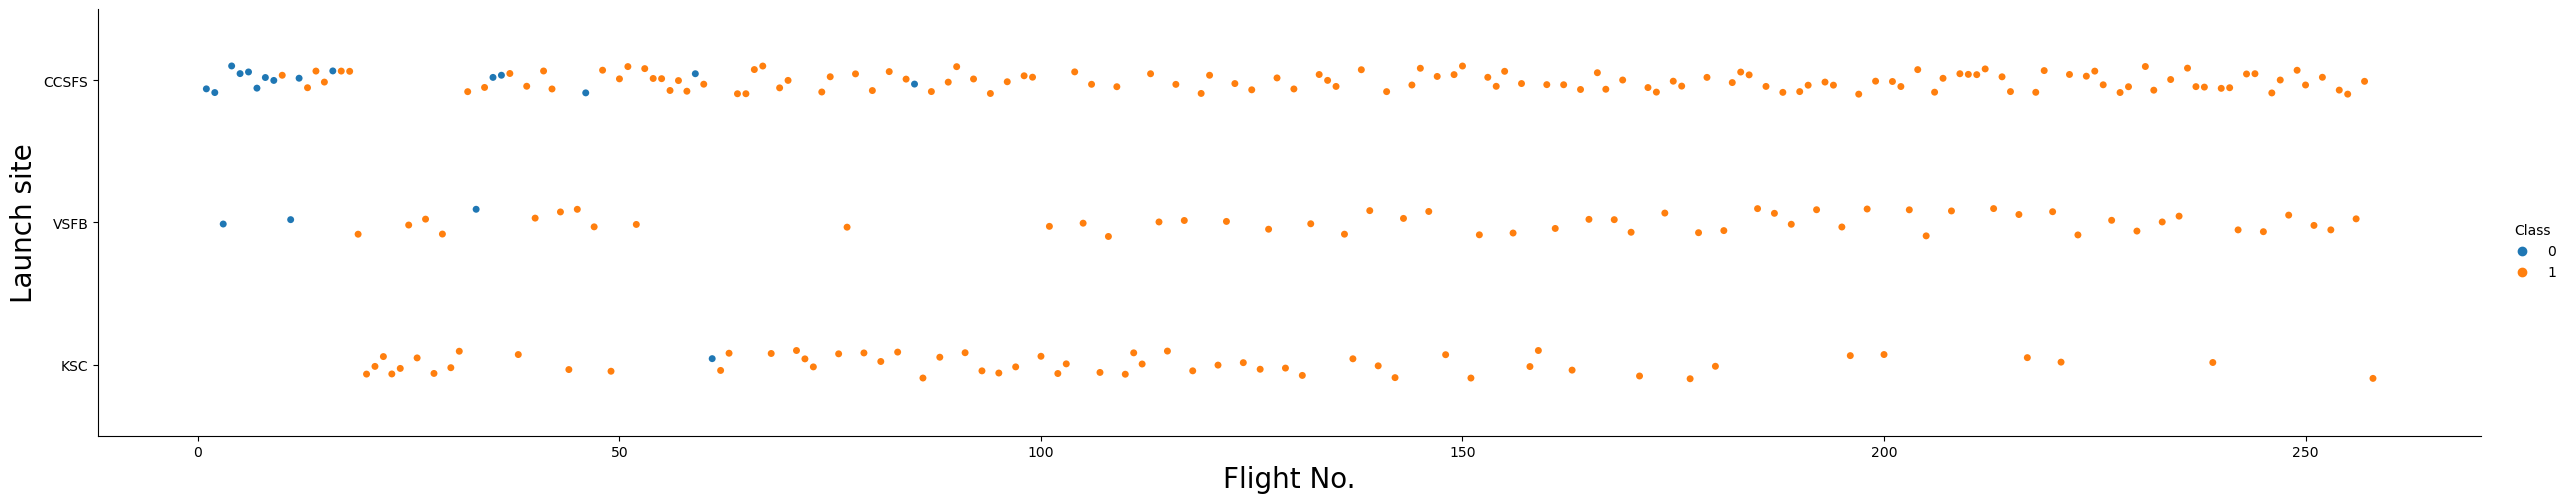

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(y='Launch site', x='Flight No.', hue='Class', data=df, aspect = 5)
plt.xlabel('Flight No.',fontsize=20)
plt.ylabel('Launch site',fontsize=20)

CCSFS had the most failures, VSFB has 3 failures and KSC only has 1 faluire. The different launch site has different success rate. 

(0.0, 20000.0)

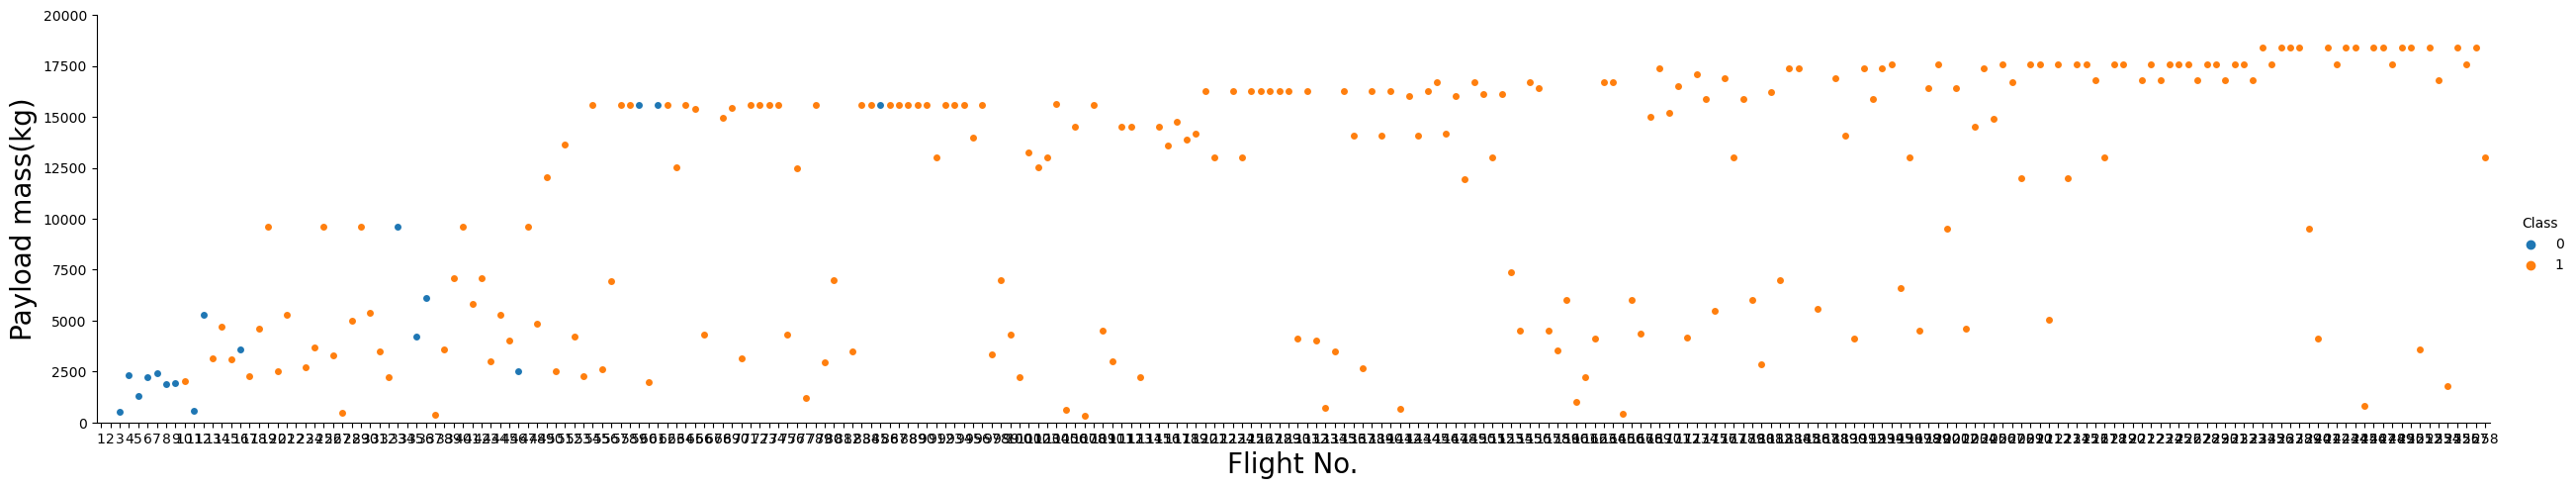

In [45]:
sns.catplot(y='Payload mass', x='Flight No.', hue='Class', data=df, aspect = 5)
plt.xlabel('Flight No.',fontsize=20)
plt.ylabel('Payload mass(kg)',fontsize=20)
plt.ylim([0,20000])

The failures were mostly low flight numbers. With more launch practices, the success rate increased.

Text(34.58494791666668, 0.5, 'Orbit')

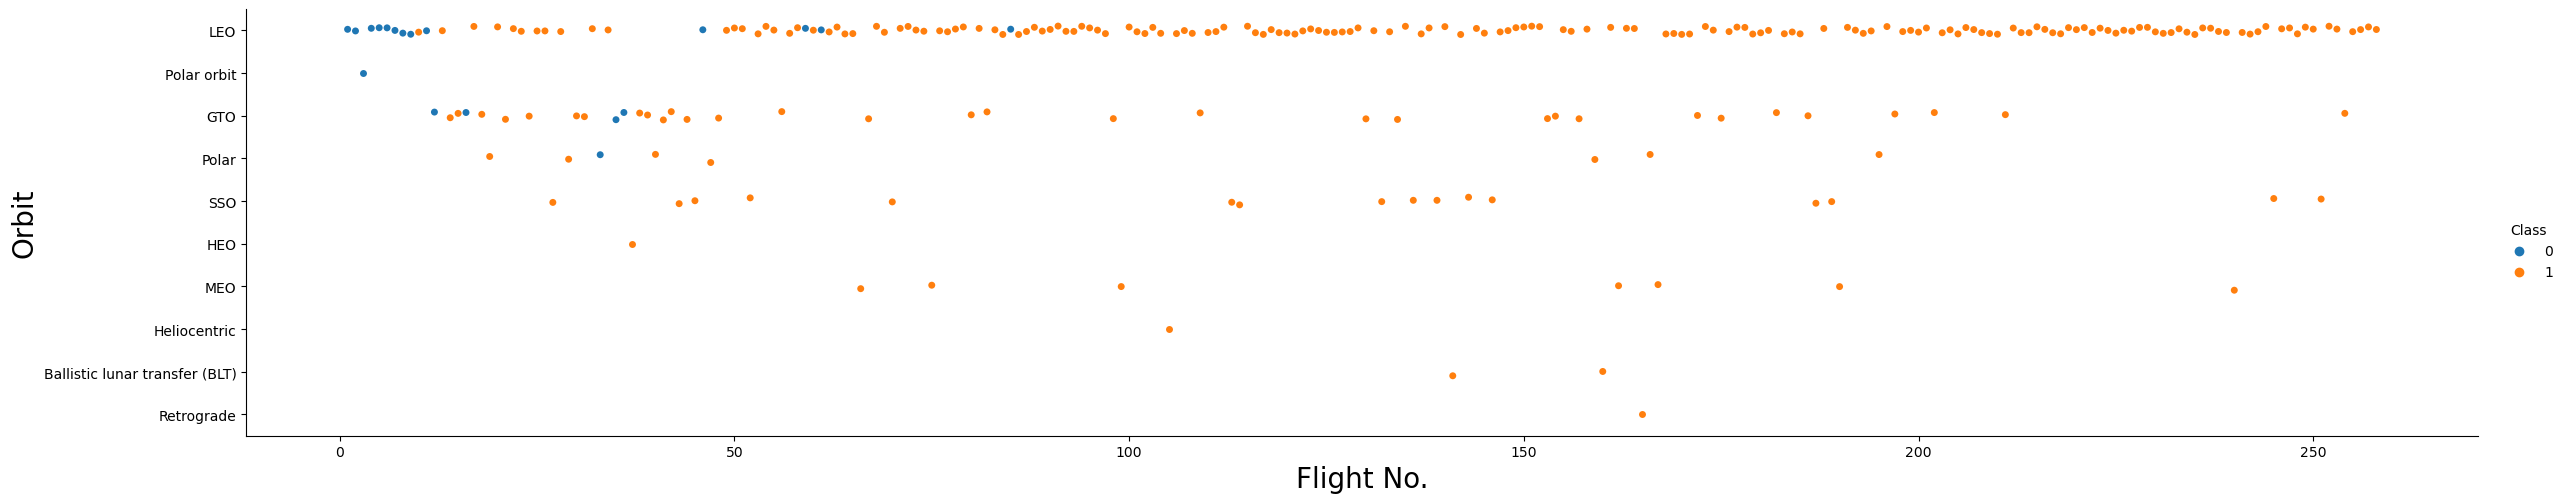

In [46]:
sns.catplot(y='Orbit', x='Flight No.', hue='Class', data=df, aspect = 5)
plt.xlabel('Flight No.',fontsize=20)
plt.ylabel('Orbit',fontsize=20)

Diferent orbit has differetn sucess rate. LEO orbit had the most launches. 

Text(31.926741666666658, 0.5, 'Landing Pad')

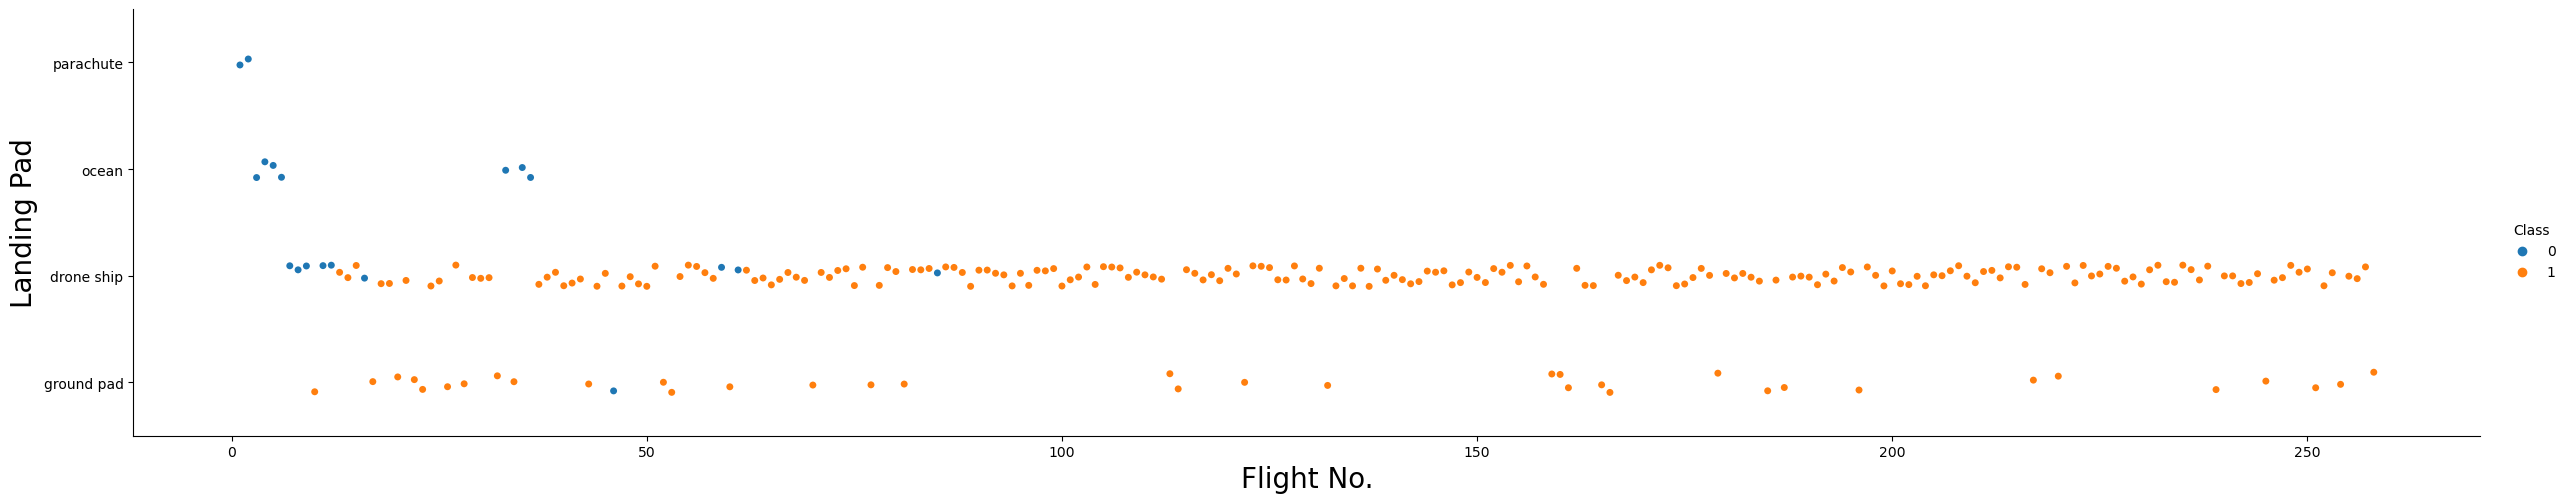

In [47]:
sns.catplot(y='Landing Pad', x='Flight No.', hue='Class', data=df, aspect = 5)
plt.xlabel('Flight No.',fontsize=20)
plt.ylabel('Landing Pad',fontsize=20)

Parachute and ocean landing pad were all not successful. In the early time, there were some failures on drone ship. Only one failure happened on groud pad. Drone ship and ground pad have higher success rate.

#### Visualize relationship between `Payload mass` and `Launch site`, `Orbit`, and `Landing Pad`

(0.0, 20000.0)

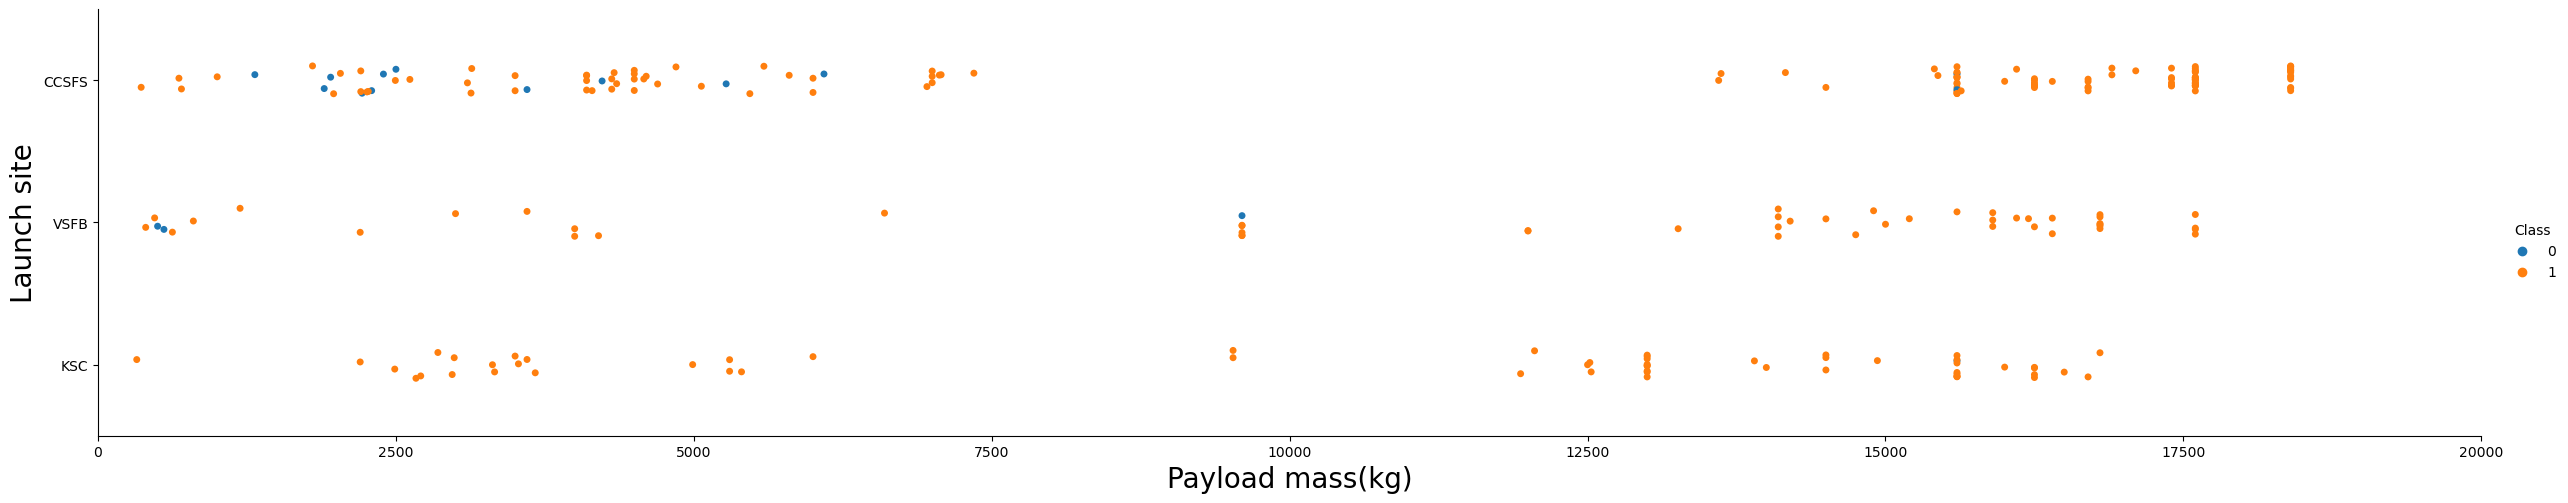

In [48]:
sns.catplot(y='Launch site', x='Payload mass', hue='Class', data=df, aspect = 5)
plt.xlabel('Payload mass(kg)',fontsize=20)
plt.ylabel('Launch site',fontsize=20)
plt.xlim([0,20000])

Low payload mass at CCSFS and VSFB have the most failures. 

(0.0, 20000.0)

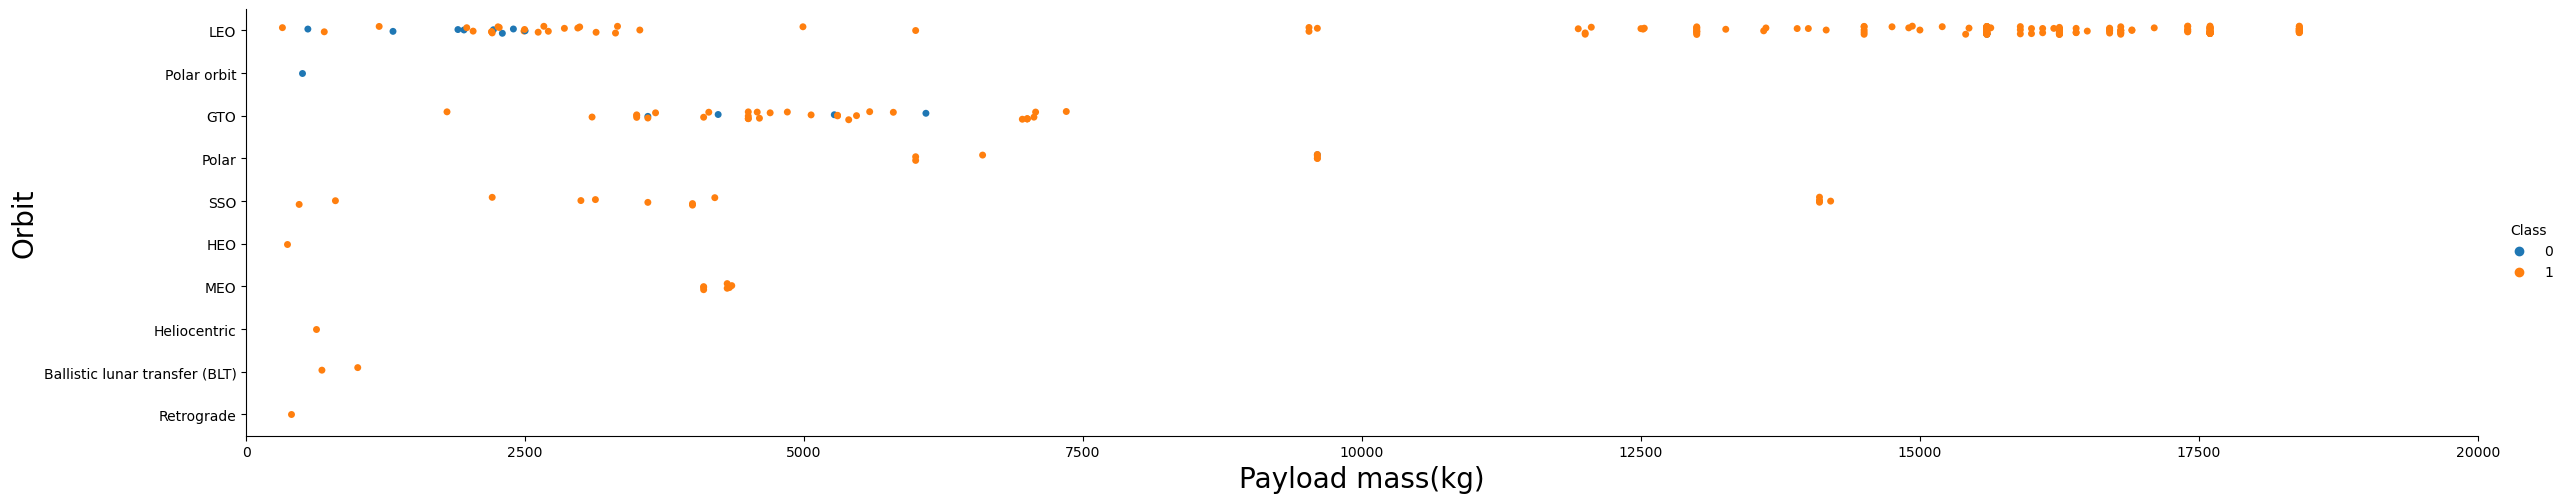

In [49]:
sns.catplot(y='Orbit', x='Payload mass', hue='Class', data=df, aspect = 5)
plt.xlabel('Payload mass(kg)',fontsize=20)
plt.ylabel('Orbit',fontsize=20)
plt.xlim([0,20000])

Low payload mass fro LEO orbit failed more.

(0.0, 20000.0)

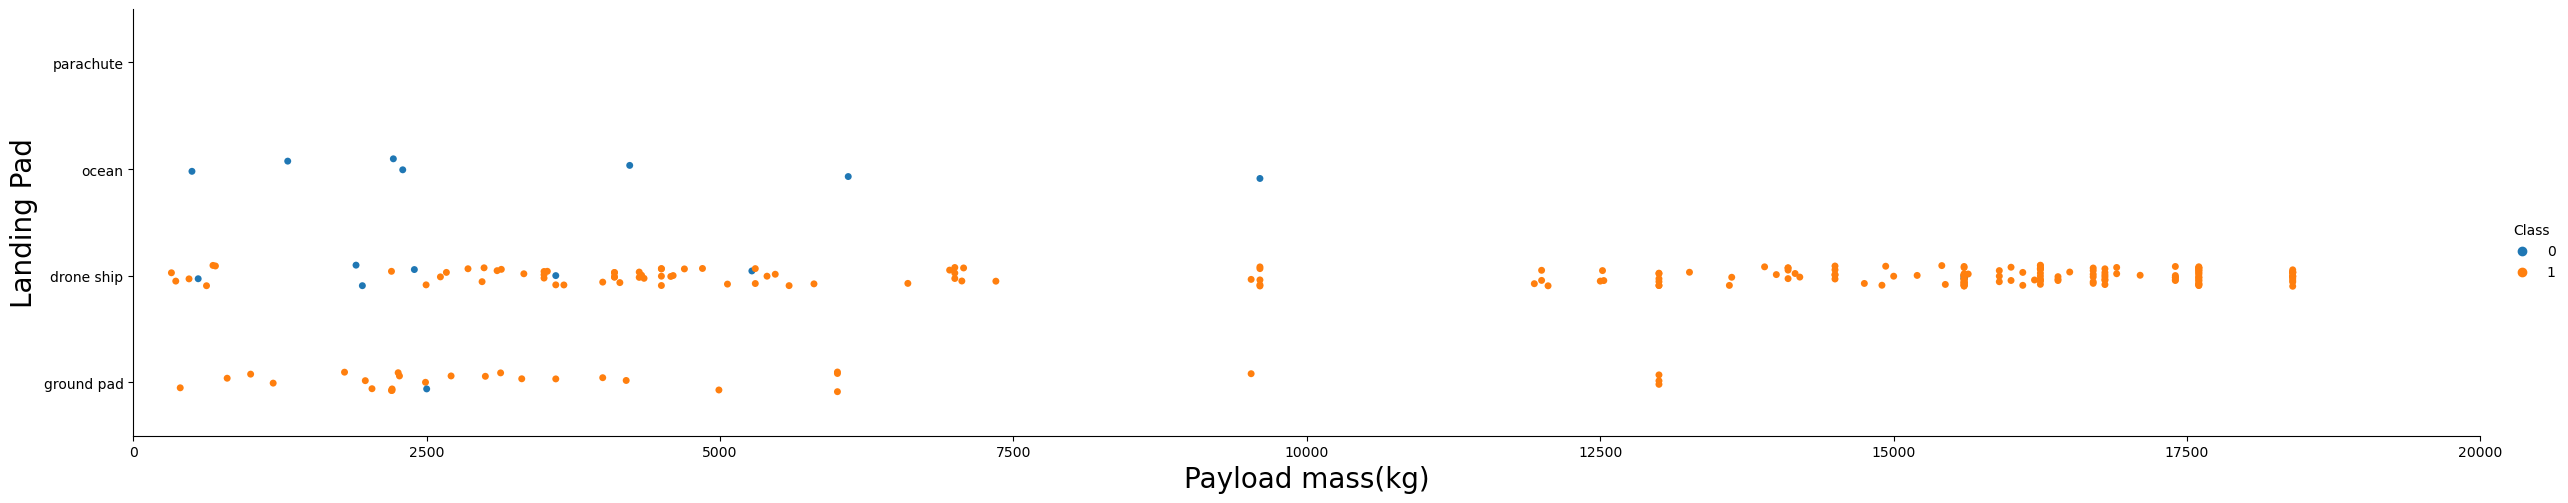

In [50]:
sns.catplot(y='Landing Pad', x='Payload mass', hue='Class', data=df, aspect = 5)
plt.xlabel('Payload mass(kg)',fontsize=20)
plt.ylabel('Landing Pad',fontsize=20)
plt.xlim([0,20000])

The failures of parachute had weight more than 2ooookg, which are not shown here. Parachute were used for large payload mass. Ocean were used for low to medium payload mass. The other two landing pads were used for all types of payload mass. 

#### Visualize relationship between `Launch site` and `Orbit`, and `Landing Pad`

Text(34.58494791666668, 0.5, 'Orbit')

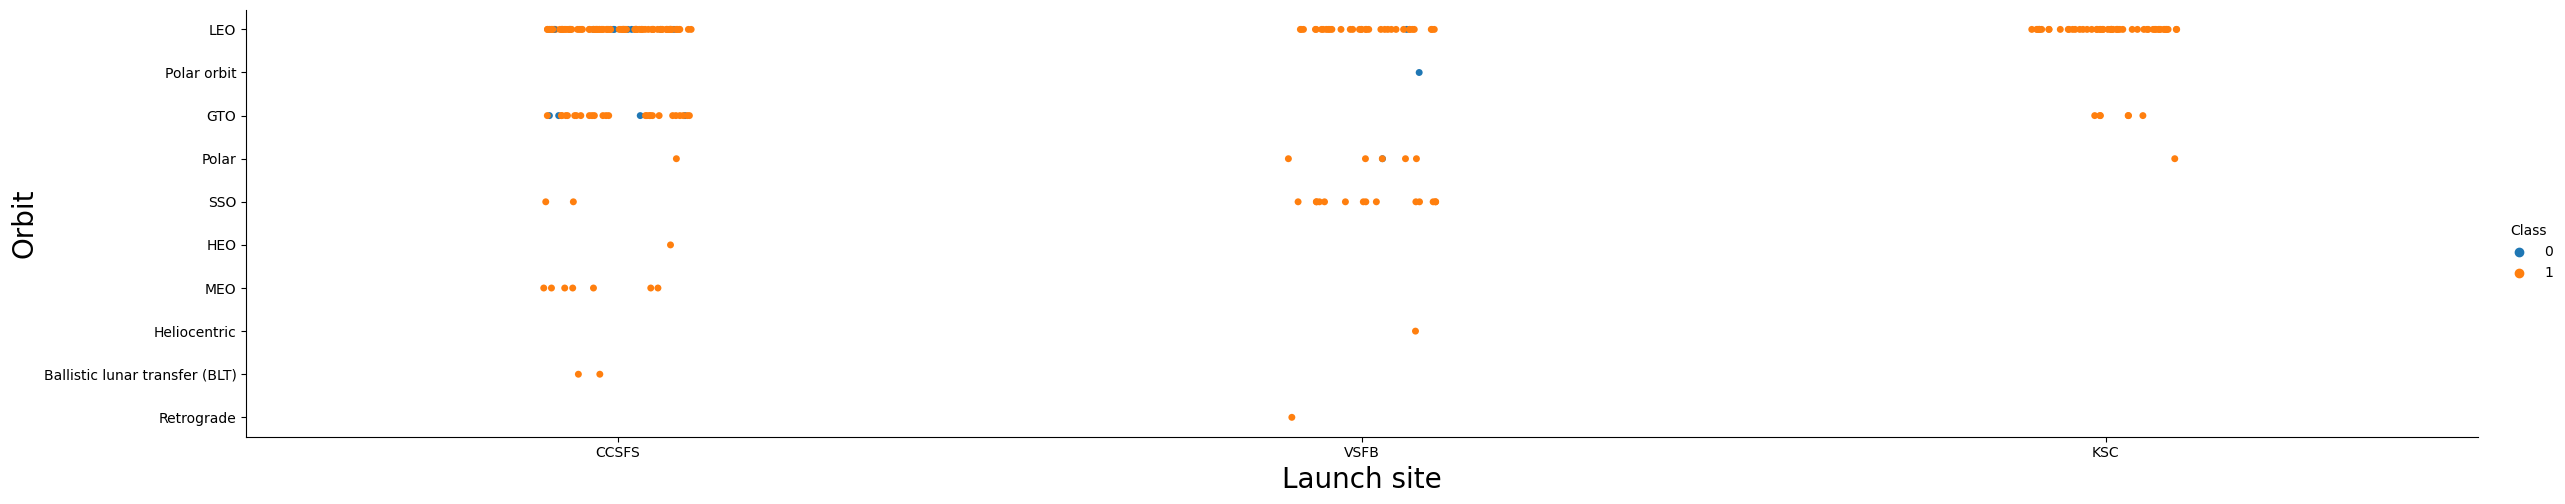

In [51]:
sns.catplot(y='Orbit', x='Launch site', hue='Class', data=df, aspect = 5)
plt.xlabel('Launch site',fontsize=20)
plt.ylabel('Orbit',fontsize=20)

CCSFS site have all oribits. KSC was used for LEO, GTO and Polar. 

Text(31.926741666666658, 0.5, 'Landing Pad')

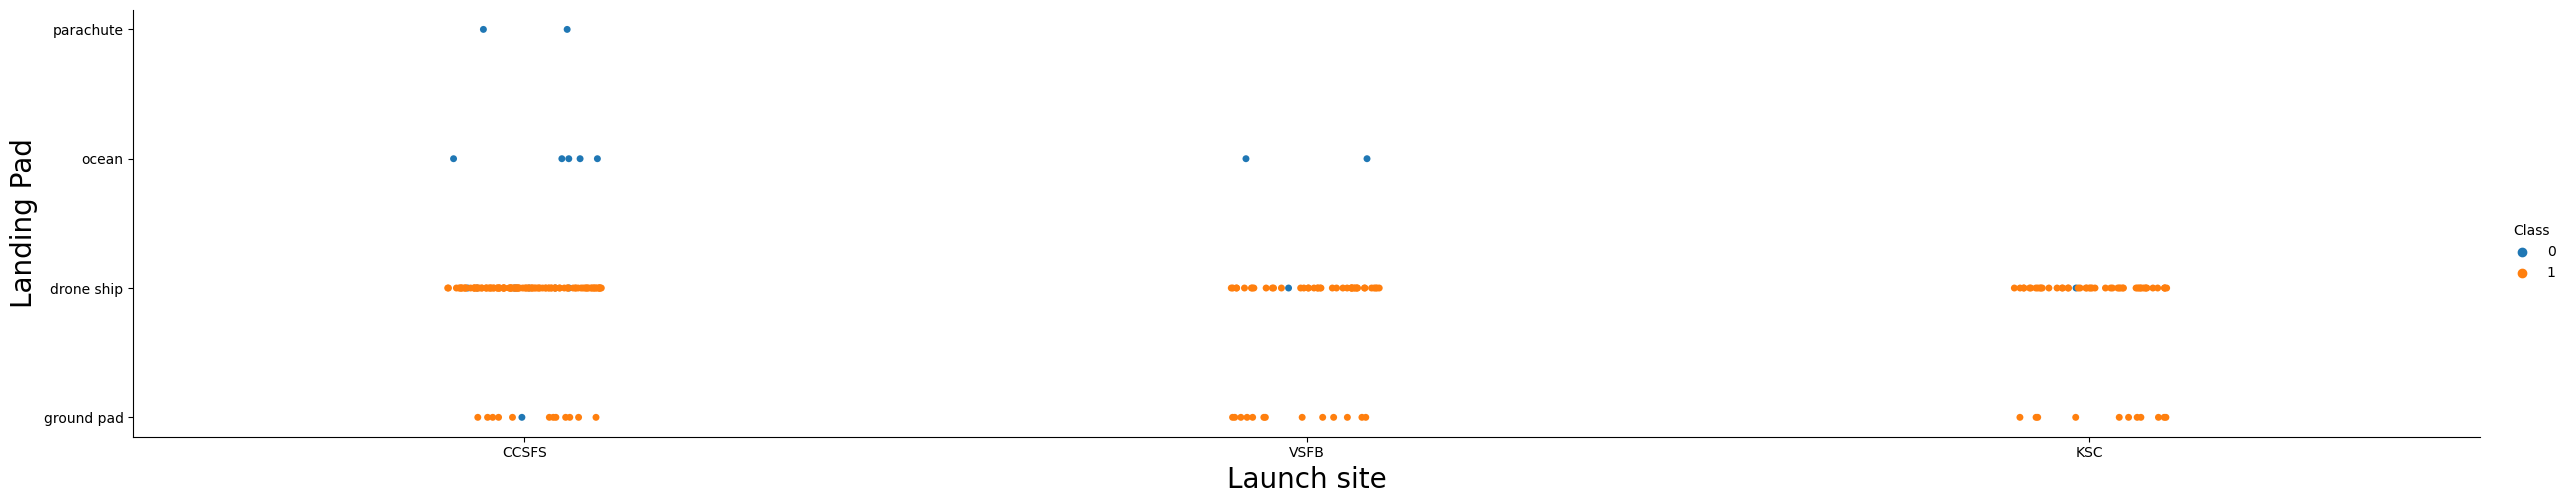

In [52]:
sns.catplot(y='Landing Pad', x='Launch site', hue='Class', data=df, aspect = 5)
plt.xlabel('Launch site',fontsize=20)
plt.ylabel('Landing Pad',fontsize=20)

The parachute, ocean landing pads were tested for site CCSFS and VSFB. 

#### Visualize success rate related to other varaibels. 

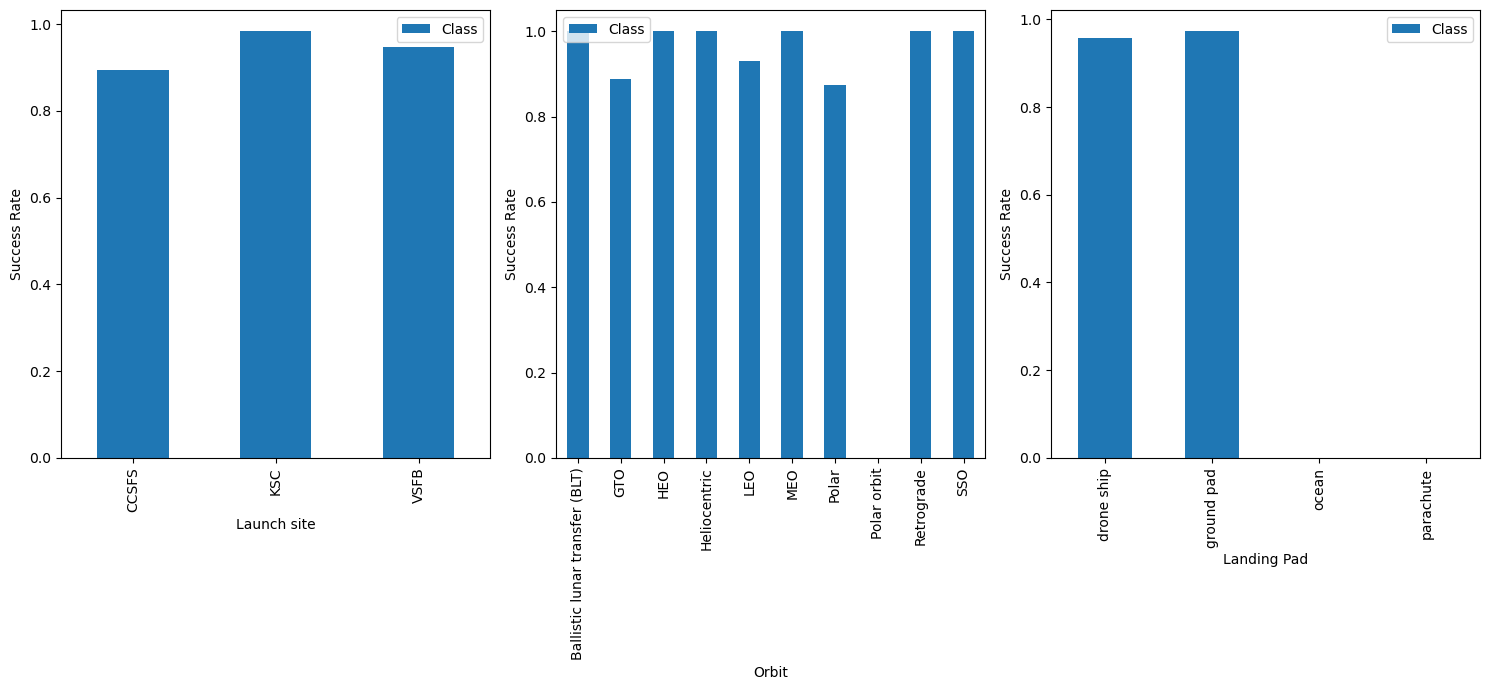

In [53]:

fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(1,3,1)
df_site = df[['Launch site','Class']]
df_bar = df_site.groupby(by=['Launch site']).mean()
df_bar.plot(kind='bar', ax=ax)
plt.xlabel('Launch site') # add to x-label to the plot
plt.ylabel('Success Rate') # add y-label to the plot
plt.tight_layout()

ax = fig.add_subplot(1,3,2)
df_orbit = df[['Orbit','Class']]
df_bar = df_orbit.groupby(by=['Orbit']).mean()
df_bar.plot(kind='bar', ax=ax)
plt.xlabel('Orbit') # add to x-label to the plot
plt.ylabel('Success Rate') # add y-label to the plot
plt.tight_layout()

ax = fig.add_subplot(1,3,3)
df_pad = df[['Landing Pad','Class']]
df_bar = df_pad.groupby(by=['Landing Pad']).mean()
df_bar.plot(kind='bar', ax=ax)
plt.xlabel('Landing Pad') # add to x-label to the plot
plt.ylabel('Success Rate') # add y-label to the plot
plt.tight_layout()

#### Visualize success rate yearly trend

In [54]:
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split(" ")[2])
    return year
Extract_year()
df['Date'] = year
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Landing Pad,Date,Time,Class
0,1,CCSFS,Dragon Spacecraft Qualification Unit,193693.468864,LEO,SpaceX,Success,F9 v1.0,Failure,parachute,2010,18:45,0
1,2,CCSFS,SpaceX COTS Demo Flight 1,193693.468864,LEO,NASA,Success,F9 v1.0,Failure,parachute,2010,15:43,0
5,3,VSFB,CASSIOPE,500.000000,Polar orbit,MDA,Success,F9 v1.1,Uncontrolled,ocean,2013,16:00,0
8,4,CCSFS,SpaceX CRS-3,2296.000000,LEO,NASA,Success,F9 v1.1,Controlled,ocean,2014,19:25,0
9,5,CCSFS,Orbcomm-OG2,1316.000000,LEO,Orbcomm,Success,F9 v1.1,Controlled,ocean,2014,15:15,0


Text(0.5, 1.0, 'Success Rate in Year')

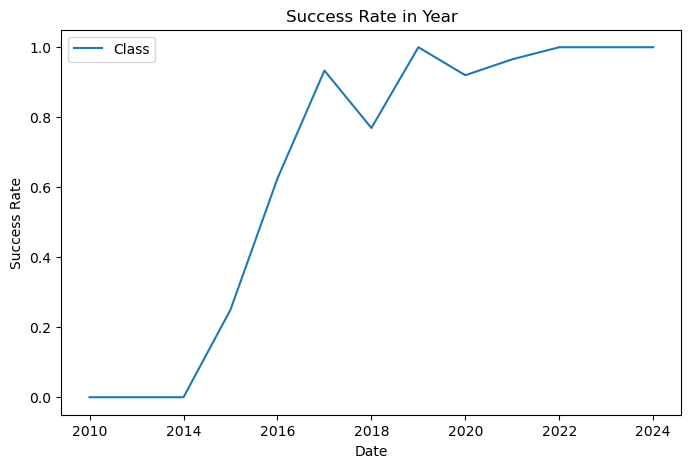

In [55]:
df_date = df[['Date','Class']]
df_line = df_date.groupby(by=['Date']).mean()
df_line.plot(kind='line', figsize=(8, 5))
plt.xlabel('Date') # add to x-label to the plot
plt.ylabel('Success Rate') # add y-label to the plot
plt.title('Success Rate in Year') # add title to the plot

We can see after 2014, the success rate kept increasing. 

After above analysis, we are ready to build a model to predict the outcome of Falcon 9 First stage landing.

### 4. Model Development

In this section, we will develop several models to predict the outcome. These models are Logistic Regresssion, SVC, Decision Tree Classifier, KNN classifier.

In [56]:
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [57]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

#### 4.0 Data Preprocessing

Data preprocessing such as scaling/normalization is typically useful for linear models to accelerate the training convergence

In [58]:
# Create dummy variables to categorical columns
#select features
features = df[['Flight No.', 'Launch site', 'Payload mass', 'Orbit', 'Landing Pad']]

In [59]:
features_one_hot = pd.get_dummies(data=features,columns=['Orbit', 'Launch site', 'Landing Pad'], dtype='float')
features_one_hot.head()

,Flight No.,Payload mass,Orbit_Ballistic lunar transfer (BLT),Orbit_GTO,Orbit_HEO,Orbit_Heliocentric,Orbit_LEO,Orbit_MEO,Orbit_Polar,Orbit_Polar orbit,Orbit_Retrograde,Orbit_SSO,Launch site_CCSFS,Launch site_KSC,Launch site_VSFB,Landing Pad_drone ship,Landing Pad_ground pad,Landing Pad_ocean,Landing Pad_parachute
0,1,193693.468864,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,193693.468864,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,3,500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,4,2296.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,5,1316.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
#change the data types all to float
features_one_hot = features_one_hot.astype(float)

In [61]:
Y = df['Class'].to_numpy()

In [62]:
X = features_one_hot
X.describe()

,Flight No.,Payload mass,Orbit_Ballistic lunar transfer (BLT),Orbit_GTO,Orbit_HEO,Orbit_Heliocentric,Orbit_LEO,Orbit_MEO,Orbit_Polar,Orbit_Polar orbit,Orbit_Retrograde,Orbit_SSO,Launch site_CCSFS,Launch site_KSC,Launch site_VSFB,Landing Pad_drone ship,Landing Pad_ground pad,Landing Pad_ocean,Landing Pad_parachute
count,258.000000,2.580000e+02,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.00000,258.000000,258.000000,258.000000,258.000000
mean,129.500000,2.119987e+05,0.007752,0.139535,0.003876,0.003876,0.717054,0.027132,0.031008,0.003876,0.003876,0.062016,0.546512,0.232558,0.22093,0.821705,0.143411,0.027132,0.007752
std,74.622383,3.112308e+06,0.087874,0.347177,0.062257,0.062257,0.451306,0.162783,0.173676,0.062257,0.062257,0.241652,0.498800,0.423284,0.41568,0.383504,0.351173,0.162783,0.087874
min,1.000000,3.250000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,65.250000,4.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
50%,129.500000,1.450000e+04,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
75%,193.750000,1.670000e+04,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
max,258.000000,5.000600e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [63]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

In [64]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=4)

#### 4.1 Logistic Regression 

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [67]:
LR = LogisticRegression()

In [68]:
logreg_cv = GridSearchCV(LR, parameters, cv=10)
logreg_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [69]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
LR_Best_Score = logreg_cv.best_score_
print("accuracy :",LR_Best_Score)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.9661904761904762


In [70]:
import sklearn.metrics as metrics
LR_scr = logreg_cv.score(x_test, y_test)
print("Test set accuracy is ",round(LR_scr,2))
predictions = logreg_cv.predict(x_test)
LR_Accuracy_Score = metrics.accuracy_score(y_test, predictions)
LR_JaccardIndex = metrics.jaccard_score(y_test, predictions)
LR_F1_Score = metrics.f1_score(y_test, predictions)
LR_Roc_AUC_Score = metrics.roc_auc_score(y_test, predictions)
print("LR Accuracy Score: ", round(LR_Accuracy_Score,2))
print("LR JaccardIndex: ", round(LR_JaccardIndex,2))
print("LR F1 Score: ", round(LR_F1_Score,2))
print("LR Roc Auc Score: " , round(LR_Roc_AUC_Score,2))

Test set accuracy is  0.92
LR Accuracy Score:  0.92
LR JaccardIndex:  0.92
LR F1 Score:  0.96
LR Roc Auc Score:  0.6


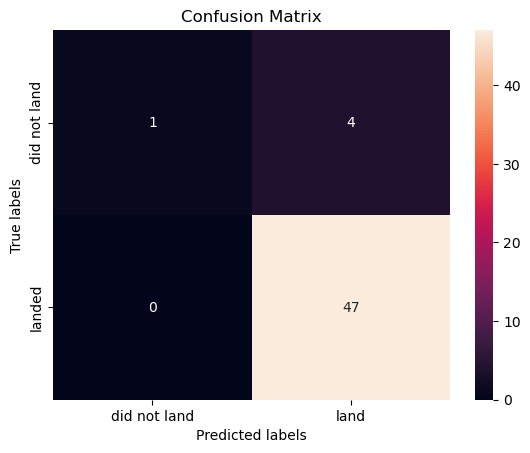

In [71]:
plot_confusion_matrix(y_test,predictions)

The accuracy of logistic regression is good. 

#### 4.2 SVM

In [72]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [73]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [74]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
SVM_Best_Score = svm_cv.best_score_
print("accuracy :",SVM_Best_Score)

tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 0.001, 'kernel': 'linear'}
accuracy : 0.9759523809523809


In [75]:
SVM_scr = svm_cv.score(x_test, y_test)
print("Test set accuracy is ",round(SVM_scr,2))
predictions = svm_cv.predict(x_test)
SVM_Accuracy_Score = metrics.accuracy_score(y_test, predictions)
SVM_JaccardIndex = metrics.jaccard_score(y_test, predictions)
SVM_F1_Score = metrics.f1_score(y_test, predictions)
SVM_Roc_AUC_Score = metrics.roc_auc_score(y_test, predictions)
print("SVM Accuracy Score: ", round(SVM_Accuracy_Score,2))
print("SVM JaccardIndex:  ", round(SVM_JaccardIndex,2))
print("SVM F1 Score:  ", round(SVM_F1_Score,2))
print("SVM Roc Auc Score:  ", round(SVM_Roc_AUC_Score,2))

Test set accuracy is  0.94
SVM Accuracy Score:  0.94
SVM JaccardIndex:   0.94
SVM F1 Score:   0.97
SVM Roc Auc Score:   0.7


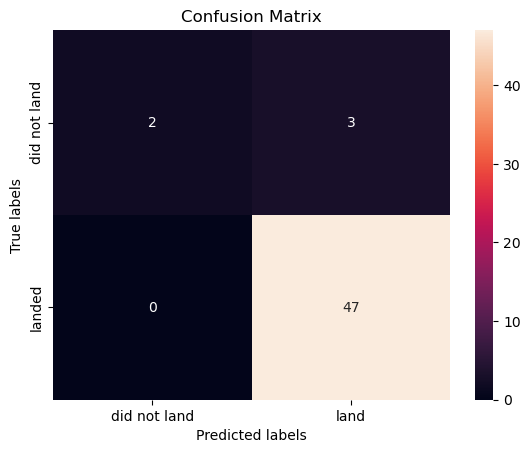

In [76]:
yhat=svm_cv.predict(x_test)
plot_confusion_matrix(y_test,yhat)

The accuracy of SVM is slightly better than logistic regression.

#### 4.3 Decision Tree Classifier

In [77]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [78]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [79]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
Tree_Best_Score = tree_cv.best_score_
print("accuracy :", round(Tree_Best_Score,2))

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.98


In [80]:
Tree_scr = tree_cv.score(x_test, y_test)
predictions = tree_cv.predict(x_test)
Tree_Accuracy_Score = metrics.accuracy_score(y_test, predictions)
Tree_JaccardIndex = metrics.jaccard_score(y_test, predictions)
Tree_F1_Score = metrics.f1_score(y_test, predictions)
Tree_Roc_AUC_Score = metrics.roc_auc_score(y_test, predictions)
print("Test set accuracy is ",round(Tree_scr,2))
print("Tree Accuracy Score: ",round(Tree_Accuracy_Score,2))
print("Tree JaccardIndex: ",round(Tree_JaccardIndex,2))
print("Tree F1 Score: ",round(Tree_F1_Score,2))
print("Tree Roc Auc Score: ",round(Tree_Roc_AUC_Score,2))

Test set accuracy is  0.96
Tree Accuracy Score:  0.96
Tree JaccardIndex:  0.96
Tree F1 Score:  0.98
Tree Roc Auc Score:  0.8


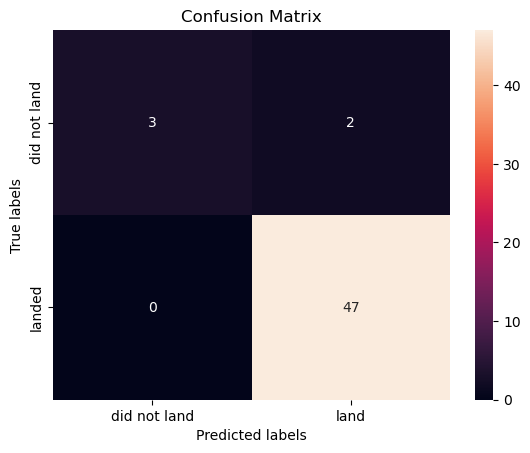

In [81]:
yhat = tree_cv.predict(x_test)
plot_confusion_matrix(y_test,yhat)

The accuracy of decision tree classifier is same as logistic regression.

#### 4.4 KNeighbors Classifier

In [82]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [83]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [84]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
KNN_Best_Score = knn_cv.best_score_
print("accuracy :", round(KNN_Best_Score,2))

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}
accuracy : 0.97


In [85]:
KNN_scr = knn_cv.score(x_test, y_test)
predictions = tree_cv.predict(x_test)
KNN_Accuracy_Score = metrics.accuracy_score(y_test, predictions)
KNN_JaccardIndex = metrics.jaccard_score(y_test, predictions)
KNN_F1_Score = metrics.f1_score(y_test, predictions)
KNN_Roc_AUC_Score = metrics.roc_auc_score(y_test, predictions)
print("Test set accuracy is ",round(KNN_scr,2))
print("KNN Accuracy Score:",round(KNN_Accuracy_Score,2))
print("KNN JaccardIndex: ",round(KNN_JaccardIndex,2))
print("KNN F1 Score: ",round(KNN_F1_Score,2))
print("KNN Roc Auc Score: ",round(KNN_Roc_AUC_Score,2))

Test set accuracy is  0.94
KNN Accuracy Score: 0.96
KNN JaccardIndex:  0.96
KNN F1 Score:  0.98
KNN Roc Auc Score:  0.8


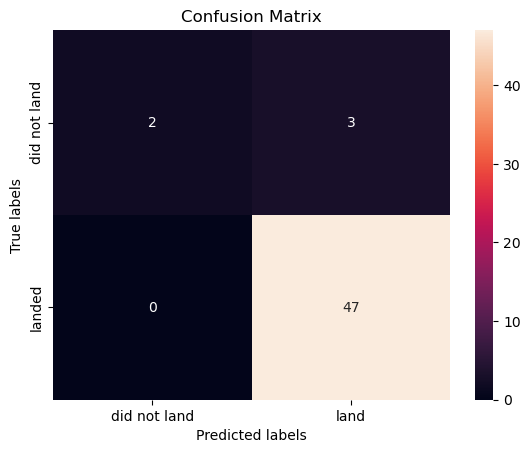

In [86]:
yhat = knn_cv.predict(x_test)
plot_confusion_matrix(y_test,yhat)

#### 4.5 Report

In [87]:
Report = pd.DataFrame([['LR',LR_Best_Score,LR_scr,LR_Accuracy_Score,LR_JaccardIndex,LR_F1_Score,LR_Roc_AUC_Score],
                       ['SVM',SVM_Best_Score,SVM_scr,SVM_Accuracy_Score,SVM_JaccardIndex,SVM_F1_Score,SVM_Roc_AUC_Score],
                       ['Decision Tree',Tree_Best_Score,Tree_scr,Tree_Accuracy_Score,Tree_JaccardIndex,Tree_F1_Score,Tree_Roc_AUC_Score],
                       ['KNN',KNN_Best_Score,KNN_scr,KNN_Accuracy_Score,KNN_JaccardIndex,KNN_F1_Score,KNN_Roc_AUC_Score]],
                      columns=['Algorithm','Accuracy','Test set accuracy','Accuracy Score','JaccardIndex','F1-Score', 'Roc Auc Score'])
Report

,Algorithm,Accuracy,Test set accuracy,Accuracy Score,JaccardIndex,F1-Score,Roc Auc Score
0,LR,0.966190,0.923077,0.923077,0.921569,0.959184,0.6
1,SVM,0.975952,0.942308,0.942308,0.940000,0.969072,0.7
2,Decision Tree,0.980714,0.961538,0.961538,0.959184,0.979167,0.8
3,KNN,0.966429,0.942308,0.961538,0.959184,0.979167,0.8


Compared four models, SVM has the best accuracy for those data. 

However, rocket science is extremly complex. There are many factors affecting the outcome of first stage landing. Those feactures we analyzed here do not fully cover the whole process of lauching a rocket and reclaiming the first stage. 